# Imports

In [1]:
# Planetary computer Search
from pystac_client import Client
import planetary_computer as pc

# DataFrames - Read and Write
import pandas as pd
import numpy as np
import geopandas as gpd

# Raster Operations
import rioxarray as rxr
from xrspatial.zonal import stats

# Raster Visualization (xArray can be used but computation heavy) 
import rasterio
from rasterio import windows
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Load Boundary data

In [2]:
def check_projection(geo_df):
    current_crs = geo_df.crs 
    if current_crs == 4326 :
        return geo_df 
    else : 
        geo_df = geo_df.to_crs("4326")
        return geo_df

In [3]:
delhi_subdistricts = gpd.read_file('delhi.gpkg')
delhi_subdistricts = check_projection(delhi_subdistricts)

In [4]:
# set this as defalt CRS, this CRS will be used for all data
def_crs = delhi_subdistricts.crs
def_crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [5]:
# get bounding box around delhi region. 
# This values will be ised to query the Planetary computer data catalog
delhi = delhi_subdistricts.dissolve()
bounds_df = delhi.bounds.squeeze()
bounds = [bounds_df['minx'], bounds_df['miny'], bounds_df['maxx'], bounds_df['maxy']]
bounds

[76.83967590307624, 28.404384613020298, 77.34802246082981, 28.883295059185293]

# Query for Landcover (raster)

In [6]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = catalog.search(collections=["esa-worldcover"], bbox=bounds)

items = list(search.get_items())
print(f"Returned {len(items)} Items")

Returned 1 Items


In [7]:
asset_href = items[0].assets["map"].href
print(asset_href)

https://ai4edataeuwest.blob.core.windows.net/esa-worldcover/v100/2020/map/ESA_WorldCover_10m_2020_v100_N27E075_Map.tif


In [8]:
signed_href = pc.sign(asset_href)

# Landcover visualization 

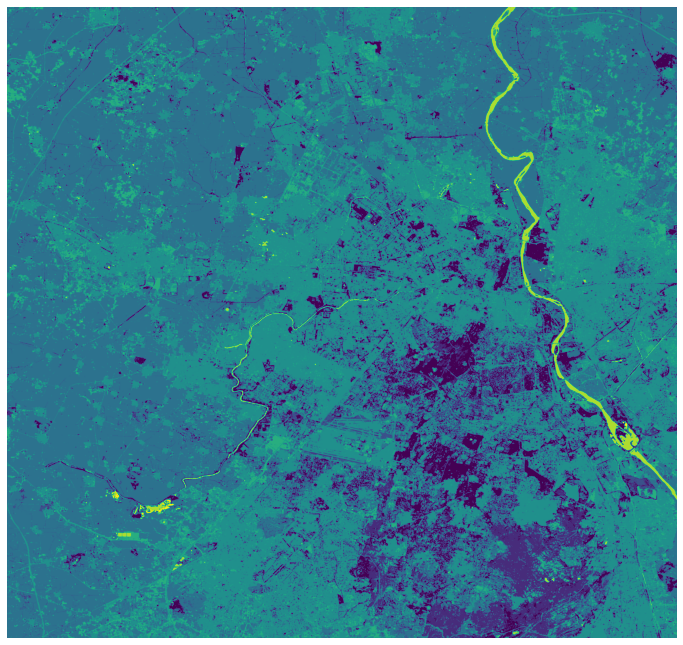

In [12]:
with rasterio.open(signed_href) as src:
    aoi_window = windows.from_bounds(transform=src.transform, *bounds)
    raster_data = src.read(1, window=aoi_window)

fig, ax = plt.subplots(figsize=(12, 12))

ax.set_axis_off()
ax.imshow(raster_data);

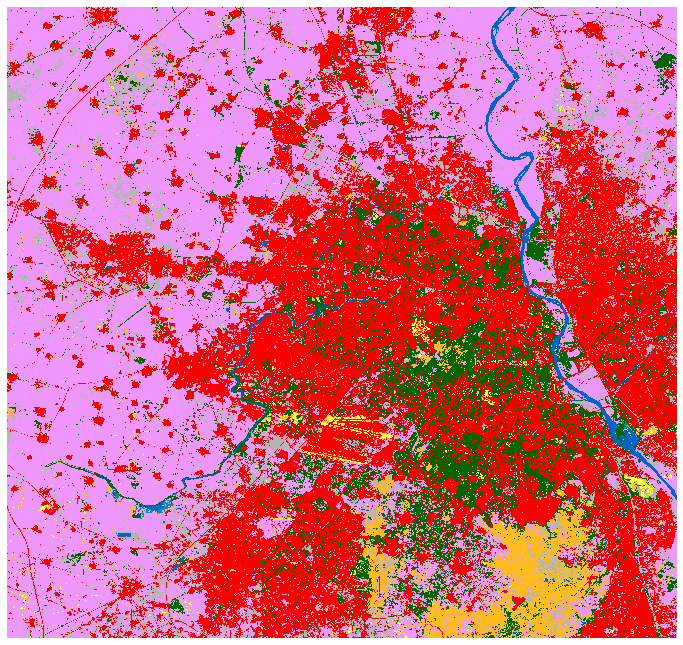

In [13]:
with rasterio.open(signed_href) as src:
    colormap_def = src.colormap(1)
    colormap = [np.array(colormap_def[i]) / 255 for i in range(len(colormap_def))]

cmap = ListedColormap(colormap)
fig, ax = plt.subplots(figsize=(12, 12))

ax.set_axis_off()
ax.imshow(raster_data, cmap=cmap, vmin=0,  vmax=(len(colormap_def) - 1),  interpolation="nearest");

# Converting to xArray DataFrame for computation

In [14]:
delhi_landcover = rxr.open_rasterio(signed_href)
delhi_landcover

<xarray.DataArray (band: 1, y: 36000, x: 36000)>
[1296000000 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 75.0 75.0 75.0 75.0 75.0 ... 78.0 78.0 78.0 78.0
  * y            (y) float64 30.0 30.0 30.0 30.0 30.0 ... 27.0 27.0 27.0 27.0
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

In [15]:
delhi_landcover_clipped = delhi_landcover.rio.clip(delhi.geometry.values, def_crs)

In [16]:
delhi_landcover_clipped.rio.to_raster("delhi_landcover_clipped.tif")

In [17]:
concatList = []
for _, sub_district in delhi_subdistricts.iterrows():
    shape_geom = sub_district['geometry']
    raster = delhi_landcover_clipped.rio.clip(shape_geom, def_crs)
    stats_df = stats(zones=raster[0], values=raster[0])
    stats_df['area_km'] = stats_df['count']*10*10/1000000
    stats_df = stats_df[['zone', 'area_km']].set_index('zone').drop(0).transpose()
    stats_df['sub_district'] = sub_district['NAME']
    concatList.append(stats_df)
area_df = pd.concat(concatList)
area_df = area_df.set_index('sub_district')

/srv/conda/envs/notebook/lib/python3.8/site-packages/rasterio/features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
/srv/conda/envs/notebook/lib/python3.8/site-packages/rasterio/features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
/srv/conda/envs/notebook/lib/python3.8/site-packages/rasterio/features.py:284: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for index, item in enumerate(shapes):
/srv/conda/envs/notebook/lib/python3.8/site-packages

In [18]:
calss_values = {
  10: "Trees",
  20: "Shrubland",
  30: "Grassland",
  40: "Cropland",
  50: "Built-up",
  60: "Barren / sparse vegetation",
  70: "Snow and ice",
  80: "Open water",
  90: "Herbaceous wetland",
  95: "Mangroves",
  100: "Moss and lichen"
}

In [19]:
area_df = area_df.rename(columns=calss_values)
area_df.head()

zone,Trees,Shrubland,Grassland,Cropland,Built-up,Barren / sparse vegetation,Open water,Herbaceous wetland
sub_district,,,,,,,,
Seelam Pur,2.3412,0.0891,0.0614,9.4618,26.5292,6.4174,1.0639,0.0007
Saraswati Vihar,21.5437,1.3756,1.4528,102.5178,99.3710,12.8964,1.3695,0.0037
Najafgarh,16.9131,2.4563,1.7569,211.3945,86.6046,17.8055,2.4912,0.3381
Gandhi Nagar,1.6909,0.0318,0.0357,2.5118,9.1508,1.0509,0.7932,0.0009
Patel Nagar,5.6351,0.0813,0.1471,0.8041,33.2076,1.5567,1.0908,NaN


# Export the csv file with area value for each category

In [20]:
area_df.to_csv('delhi_landcover_area_sqkm.csv')